In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL

In [2]:
im = cv2.imread("figures/uw.png")

In [7]:
im.shape

(198, 255, 3)

In [15]:
198*25/255

19.41176470588235

In [13]:
im = np.fliplr(im.reshape(-1,3)).reshape(im.shape)

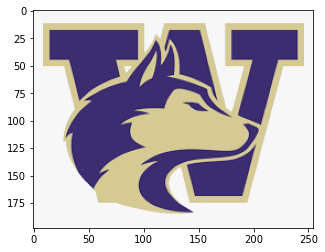

In [14]:
plt.imshow(im)

In [155]:
resized = cv2.resize(im, (25, 19), interpolation = cv2.INTER_AREA)

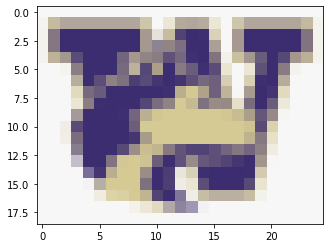

In [156]:
plt.imshow(resized)

In [157]:
resized.shape

(19, 25, 3)

In [158]:
resized[5, 3]

array([138, 125, 131], dtype=uint8)

In [159]:
resized[1, 1]

array([196, 186, 159], dtype=uint8)

In [160]:
resized[1, 3]

array([177, 166, 155], dtype=uint8)

In [161]:
resized[10, 12]

array([213, 202, 148], dtype=uint8)

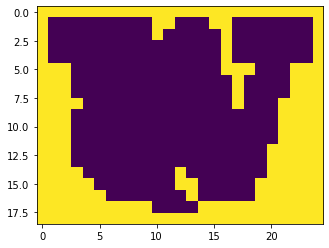

In [162]:
plt.imshow(resized[:,:,2]>=200)

In [191]:
tf_arr = resized[:,:,0]>=130

In [192]:
vi0let_mask = tf_arr.astype(int)

In [193]:
vi0let_mask.shape

(19, 25)

In [194]:
vi0let_mask[7, 5] = 1
vi0let_mask[5, 7] = 1
vi0let_mask[3, 12] = 1
vi0let_mask[4, 12] = 1
vi0let_mask[5, 13] = 1
vi0let_mask[5, 14] = 1
vi0let_mask[6, 15] = 1
vi0let_mask[6, 15] = 1

In [195]:
vi0let_mask = vi0let_mask[1:16, 1:]

In [196]:
vi0let_mask = np.logical_not(vi0let_mask).astype(int)

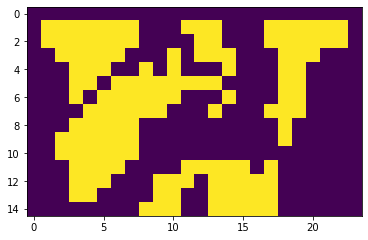

In [197]:
plt.imshow(vi0let_mask)

In [198]:
yellow_mask = np.logical_and(resized[:,:,0]>=130, resized[:,:,2]<=240).astype(int)

In [199]:
yellow_mask = yellow_mask[1:16, 1:]

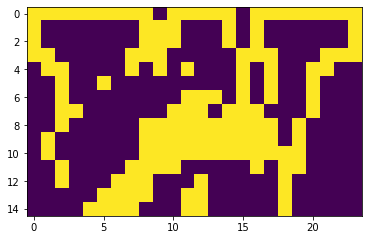

In [200]:
plt.imshow(yellow_mask)

In [201]:
yellow_mask.shape

(15, 24)

# Pipetting

In [2]:
import tools
import param
import cartesian
import racks
import calibration
import samples
import json
import importlib
import random as rnd
import time
import low_level_comm as llc

In [312]:
llc.listSerialPorts()

['COM3', 'COM6', 'COM10']

## Initializing racks and samples

In [205]:
r50 = racks.rack(rack_name='50mL_rack_1', rack_type='50mL')
rack384 = racks.rack(rack_name='384wells_rack', rack_type='384wells_rack')
waste_rack = racks.rack(rack_name='waste', rack_type='waste_rack')
p1000_tip_rack = racks.consumables(rack_name='p1000_tips_1', rack_type='p1000_tips')
p200_tip_rack = racks.consumables(rack_name='p200_tips_1', rack_type='p200_tips')
p20_tip_rack = racks.consumables(rack_name='p20_tips_1', rack_type='p20_tips')

In [113]:
def InitColour(rack, name, x, y, vol=50000):
    s = samples.sample(sample_name=name, sample_type='50mL_tube')
    s.place(rack, x, y)
    s.setVolume(vol)
    return s

In [206]:
yellow = InitColour(r50, 'yellow', 0, 0)
red = InitColour(r50, 'red', 1, 0)
blue = InitColour(r50, 'blue', 2, 0)

In [208]:
# Samples plate
p = samples.plate('husky', '384wells_plate')
p.place(rack384)

In [116]:
def createSampleVolListsByMask(mask, plate, vol):
    sample_list = []
    vol_list = []
    row_count = 0
    col_count = 0
    for i in mask:
        for j in i:
            s = plate.getSample(column=col_count, row=row_count)
            if j == 1:
                sample_list.append(s)
                vol_list.append(vol)
            col_count += 1
        row_count += 1
        col_count = 0
    return sample_list, vol_list

In [226]:
yellow_samples, yellow_vols = createSampleVolListsByMask(yellow_mask, p, 120)
red_samples, red_vols = createSampleVolListsByMask(vi0let_mask, p, 60)
blue_samples, blue_vols = createSampleVolListsByMask(vi0let_mask, p, 60)

## Initializing robot

In [313]:
ar = cartesian.arnie(cartesian_port="COM10", docker_port="COM6")

In [314]:
ar.home()

In [315]:
stp = tools.stationary_touch_probe(ar)

## Re-calibrating racks

In [215]:
tp = tools.mobile_touch_probe.getTool(ar)

In [216]:
x, y, z = calibration.calibrateStationaryProbe(tp, stp)

In [217]:
calibration.calibrateRack(tp, p1000_tip_rack)
calibration.calibrateRack(tp, p200_tip_rack)
calibration.calibrateRack(tp, p20_tip_rack)
ar.move(z=400)
calibration.calibrateRack(tp, rack384)

(690.94, 395.95000000000005, 505.75)

In [218]:
tp.returnTool()

# Filling the plate

In [219]:
p1000 = tools.pipettor.getTool(robot=ar, tool_name='p1000_tool')

In [220]:
calibration.calibrateTool(p1000, stp)

(95.25, 65.55, 426.7)

In [221]:
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=300)

In [222]:
ar.move(z=300)

In [223]:
p1000.distributeLiquid(yellow, yellow_samples, yellow_vols, raise_z=320, touch_wall=True)

In [224]:
ar.move(z=300)

In [227]:
p1000.distributeLiquid(red, red_samples, red_vols, raise_z=320, touch_wall=True)

In [228]:
ar.move(z=300)

In [229]:
p1000.distributeLiquid(blue, blue_samples, blue_vols, raise_z=320, touch_wall=True)

In [230]:
ar.move(z=300)

In [231]:
p1000.dropTipToWaste(waste_rack, raise_z=300)

In [232]:
p1000.returnTool()

In [233]:
ar.home()

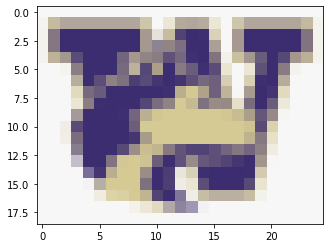

In [79]:
plt.imshow(resized)

In [87]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

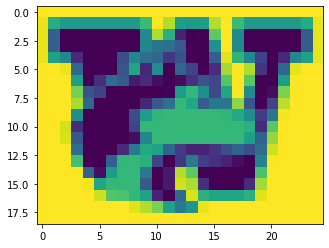

In [88]:
plt.imshow(gray)

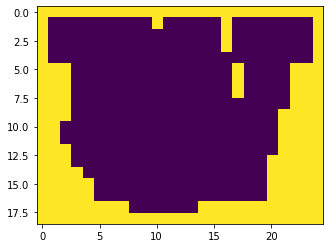

In [94]:
plt.imshow(gray>=240)

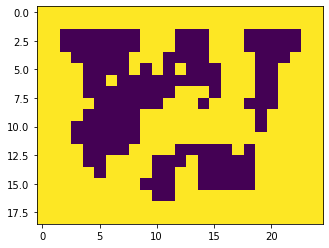

In [104]:
plt.imshow(gray>=120)

# Split-Bio

In [5]:
im = cv2.imread("figures/SplitBio_Logo_RGB_White.webp")

In [6]:
im.shape

(68, 159, 3)

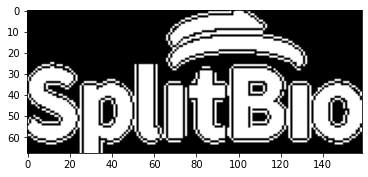

In [7]:
plt.imshow(im)

In [8]:
68*24/159

10.264150943396226

In [46]:
resized = cv2.resize(im, (24, 10), interpolation = cv2.INTER_CUBIC)

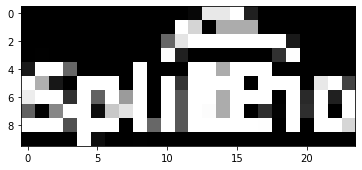

In [47]:
plt.imshow(resized)

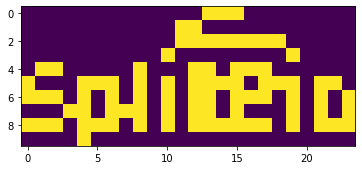

In [64]:
plt.imshow(resized[:,:,0]>=200)

In [79]:
mask = (resized[:,:,0]>=200).astype(int)

In [80]:
mask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0],
       [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 1],
       [0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [81]:
A = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]])

In [82]:
mask = np.vstack((A, mask))

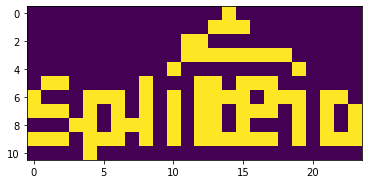

In [83]:
plt.imshow(mask)

In [102]:
mask[1, 12] = 1
mask[2, 11] = 0
mask[2, 12] = 0
mask[8, 7] = 0
mask[5, 12] = 0
mask[7, 12] = 0
mask[8, 12] = 0
mask[9, 12] = 0
mask[6, 18] = 0
mask[7, 18] = 0
mask[8, 18] = 1
mask[9, 18] = 0

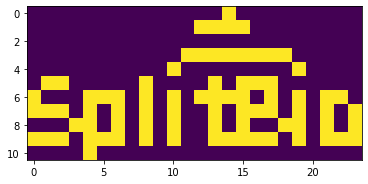

In [103]:
plt.imshow(mask)

In [104]:
A = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

In [105]:
mask = np.vstack((A, mask))
mask = np.vstack((A, mask))
mask = np.vstack((A, mask))
mask = np.vstack((A, mask))
mask = np.vstack((A, mask))

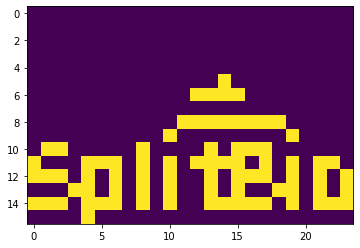

In [106]:
plt.imshow(mask)

In [107]:
violet_mask = np.logical_not(mask).astype(int)

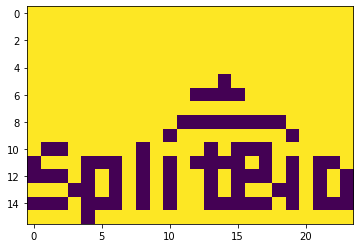

In [108]:
plt.imshow(violet_mask)

# Pipetting

In [175]:
import tools
import param
import cartesian
import racks
import calibration
import samples
import json
import importlib
import random as rnd
import time
import low_level_comm as llc
import importlib

In [176]:
importlib.reload(tools)

<module 'tools' from 'c:\\Users\\sergi\\Dropbox\\workspace\\arnielib\\tools.py'>

In [142]:
llc.listSerialPorts()

[]

In [112]:
r50 = racks.rack(rack_name='50mL_rack_1', rack_type='50mL')
rack384 = racks.rack(rack_name='384wells_rack', rack_type='384wells_rack')
waste_rack = racks.rack(rack_name='waste', rack_type='waste_rack')
p1000_tip_rack = racks.consumables(rack_name='p1000_tips_1', rack_type='p1000_tips')
p200_tip_rack = racks.consumables(rack_name='p200_tips_1', rack_type='p200_tips')
p20_tip_rack = racks.consumables(rack_name='p20_tips_1', rack_type='p20_tips')

In [310]:
yellow = InitColour(r50, 'yellow', 0, 0)
red = InitColour(r50, 'red', 1, 0)
blue = InitColour(r50, 'blue', 2, 0)

In [115]:
# Samples plate
p = samples.plate('splitbio', '384wells_plate')
p.place(rack384)

In [118]:
red_samples, red_vols = createSampleVolListsByMask(violet_mask, p, 90)
blue_samples, blue_vols = createSampleVolListsByMask(violet_mask, p, 30)

## Initialize

In [119]:
ar = cartesian.arnie(cartesian_port="COM10", docker_port="COM6")

In [140]:
ar.home()

In [121]:
stp = tools.stationary_touch_probe(ar)

In [143]:
tp = tools.mobile_touch_probe.getTool(ar)

In [144]:
calibration.calibrateStationaryProbe(tp, stp)

(94.85, 65.35, 490.15)

In [124]:
calibration.calibrateRack(tp, p1000_tip_rack)
calibration.calibrateRack(tp, p200_tip_rack)
calibration.calibrateRack(tp, p20_tip_rack)
ar.move(z=400)
calibration.calibrateRack(tp, rack384)

(691.14, 396.04999999999995, 505.45)

In [138]:
tp.returnTool()

In [177]:
p1000 = tools.pipettor.getTool(robot=ar, tool_name='p1000_tool')

In [178]:
calibration.calibrateTool(p1000, stp)

(95.25, 65.44999999999999, 426.15)

In [179]:
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=300)

In [180]:
p1000.distributeLiquid(blue, blue_samples, blue_vols, raise_z=320, touch_wall=True)

In [186]:
ar.move(z=300)

In [182]:
p1000.getToSample(blue)

In [183]:
p1000.movePlunger(-40)

In [184]:
p1000.movePlunger(-1)

In [185]:
p1000.distributeLiquid(red, red_samples, red_vols, raise_z=320, touch_wall=True)

In [ ]:
ar.move(z=300)

In [187]:
p1000.getToSample(red)

In [188]:
p1000.movePlunger(-40)

In [189]:
p1000.movePlunger(-1)

In [190]:
p1000.dropTipToWaste(waste_rack=waste_rack)

In [191]:
p1000.returnTool()

In [192]:
ar.home()

# re-calibrating pipette racks

In [145]:
p1000_rack = racks.rack(rack_name='p1000_tool_rack', rack_type='pipette_rack')
p200_rack = racks.rack(rack_name='p200_tool_rack', rack_type='pipette_rack')
p20_rack = racks.rack(rack_name='p20_tool_rack', rack_type='pipette_rack')

In [146]:
ar.move(z=300)

In [147]:
calibration.calibrateRack(tp, p1000_rack)
calibration.calibrateRack(tp, p200_rack)
calibration.calibrateRack(tp, p20_rack)

(691.79, 64.65, 444.45)

In [148]:
tp.returnTool()

# Aronora

In [201]:
im = cv2.imread("figures/aronora2.png")

In [202]:
im.shape

(161, 117, 3)

In [207]:
117*16/161

11.627329192546584

In [203]:
im = np.fliplr(im.reshape(-1,3)).reshape(im.shape)

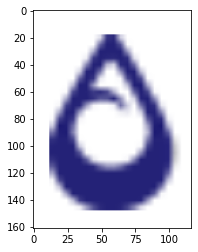

In [204]:
plt.imshow(im)

In [216]:
resized = cv2.resize(im, (16, 24), interpolation = cv2.INTER_NEAREST)

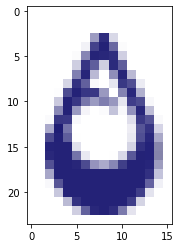

In [217]:
plt.imshow(resized)

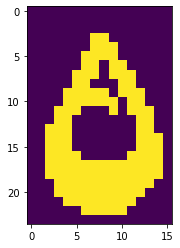

In [224]:
plt.imshow(resized[:,:,0]<=200)

In [252]:
mask = (resized[:,:,0]<=200).astype(int)

In [253]:
mask = np.transpose(mask)
mask = np.flip(mask, axis=0)

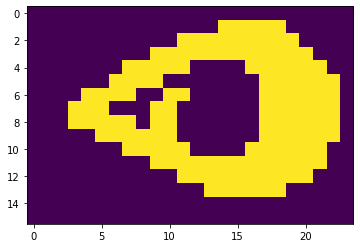

In [254]:
plt.imshow(mask)

In [255]:
blue_samples, blue_vols = createSampleVolListsByMask(mask, p, 130)

In [260]:
ar.home()

In [235]:
p1000.returnTool()

In [236]:
p1000 = tools.pipettor.getTool(robot=ar, tool_name='p1000_tool')

In [237]:
calibration.calibrateTool(p1000, stp)

(94.5, 65.25, 426.7)

In [238]:
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=300)

In [256]:
p1000.distributeLiquid(blue, blue_samples, blue_vols, raise_z=320, touch_wall=True)

In [257]:
ar.move(z=300)

In [258]:
p1000.dropTipToWaste(waste_rack=waste_rack, raise_z=300)

In [259]:
p1000.returnTool()

# Digital proteomics

In [261]:
im = cv2.imread("figures/digital_proteomics.png")

In [262]:
im.shape

(51, 200, 3)

In [263]:
im = np.fliplr(im.reshape(-1,3)).reshape(im.shape)

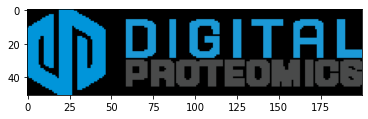

In [264]:
plt.imshow(im)

In [277]:
im = im[:, 0:47, :]

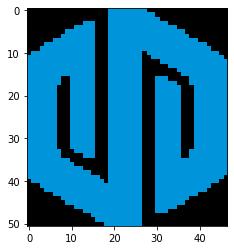

In [278]:
plt.imshow(im)

In [285]:
resized = cv2.resize(im, (16, 16), interpolation = cv2.INTER_NEAREST)

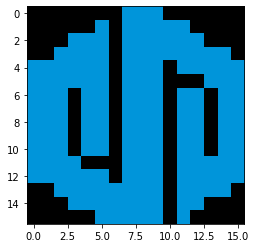

In [286]:
plt.imshow(resized)

In [302]:
mask = resized[:,:,1]>=50

In [303]:
mask = mask[:, 1:]

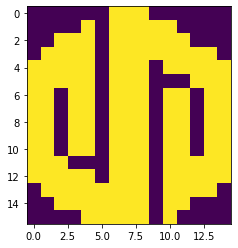

In [304]:
plt.imshow(mask)

In [305]:
A = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],])

In [306]:
mask = np.hstack((A, mask))
mask = np.hstack((A, mask))
mask = np.hstack((A, mask))
mask = np.hstack((A, mask))

mask = np.hstack((mask, A))
mask = np.hstack((mask, A))
mask = np.hstack((mask, A))
mask = np.hstack((mask, A))

In [307]:
mask.shape

(16, 23)

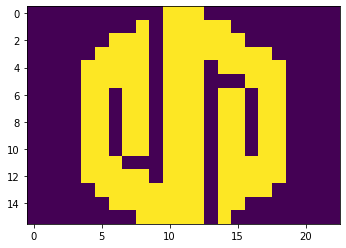

In [308]:
plt.imshow(mask)

In [309]:
blue_samples, blue_vols = createSampleVolListsByMask(mask, p, 130)

In [316]:
p1000 = tools.pipettor.getTool(robot=ar, tool_name='p1000_tool')

In [317]:
calibration.calibrateTool(p1000, stp)

(94.25, 65.44999999999999, 426.75)

In [318]:
xn, yn = p1000_tip_rack.getNextConsumable()
p1000.pickUpTip(p1000_tip_rack, xn, yn, raise_z=300)

In [319]:
p1000.distributeLiquid(blue, blue_samples, blue_vols, raise_z=320, touch_wall=True)

In [320]:
ar.move(z=300)

In [321]:
p1000.dropTipToWaste(waste_rack=waste_rack, raise_z=300)

In [322]:
p1000.returnTool()

In [323]:
ar.move(x=10, y=10)

# Admera health

In [342]:
im = cv2.imread("figures/Admera_Health_logo1.png")

In [343]:
im.shape

(63, 170, 3)

In [344]:
im = np.fliplr(im.reshape(-1,3)).reshape(im.shape)

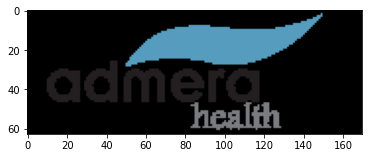

In [345]:
plt.imshow(im)

In [346]:
im = im[0:50, 7:150, :]

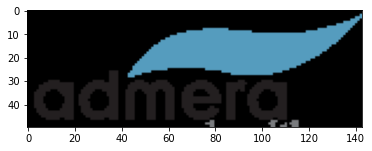

In [347]:
plt.imshow(im)

In [357]:
resized = cv2.resize(im, (24, 10), interpolation = cv2.INTER_NEAREST)

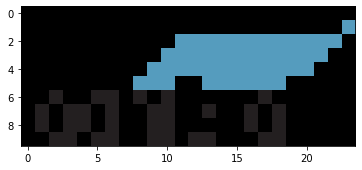

In [358]:
plt.imshow(resized)